In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pdb
import requests
import io
import os
import itertools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c
from sklearn.metrics import roc_curve, auc
sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_palette('colorblind')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
pd.options.display.max_columns = 100

Import useful tools and then my dataset 


In [42]:
url="https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv?cm_mc_uid=42350349240115511137586&cm_mc_sid_50200000=48695861551226681996&cm_mc_sid_52640000=68226791551226682000"
s=requests.get(url).content
telecom = pd.read_csv(io.StringIO(s.decode('utf-8')))
telecom.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data Manipulation

In [41]:
telecom.shape

(7032, 21)

In [6]:
# unique customers
telecom["customerID"].nunique()

7043

Examine if there are missing variables:

In [7]:
print ("\nMissing values :\n",telecom.isnull().sum())


Missing values :
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


But I noticed that in column TotalCharges there are some " " so I'll replace space with N/A and search for missing values one more time. I'll do the same for MonthlyCharges to be sure.

In [8]:
telecom['TotalCharges'] = telecom["TotalCharges"].replace(" ",np.nan)
telecom['MonthlyCharges'] = telecom["MonthlyCharges"].replace(" ",np.nan)

In [9]:
print ("\nMissing values :\n",telecom.isnull().sum())


Missing values :
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


percentange of missing values:

Text(0.5, 1.0, 'Percent Missing by Variable')

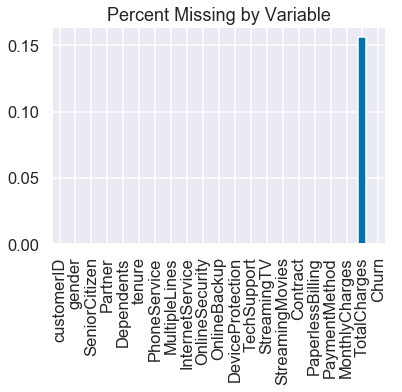

In [10]:
((telecom.isnull().sum()/len(telecom)) * 100).plot(kind='bar')
plt.title('Percent Missing by Variable')

0.15% is very low, therefore I can just drop these values from the column

In [11]:
telecom = telecom[telecom["TotalCharges"].notnull()]
telecom = telecom.reset_index()[telecom.columns]

And convert to float:

In [12]:
telecom["TotalCharges"] = telecom["TotalCharges"].astype(float)

In [13]:
print (telecom['TotalCharges'])

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
5        820.50
6       1949.40
7        301.90
8       3046.05
9       3487.95
10       587.45
11       326.80
12      5681.10
13      5036.30
14      2686.05
15      7895.15
16      1022.95
17      7382.25
18       528.35
19      1862.90
20        39.65
21       202.25
22        20.15
23      3505.10
24      2970.30
25      1530.60
26      4749.15
27        30.20
28      6369.45
29      1093.10
         ...   
7002    3756.40
7003    3645.75
7004    2874.45
7005      49.95
7006    1020.75
7007      70.65
7008     826.00
7009     239.00
7010     727.80
7011    7544.30
7012    6479.40
7013    3626.35
7014    1679.40
7015     403.35
7016     931.55
7017    4326.25
7018     263.05
7019      39.25
7020    3316.10
7021      75.75
7022    2625.25
7023    6886.25
7024    1495.10
7025     743.30
7026    1419.40
7027    1990.50
7028    7362.90
7029     346.45
7030     306.60
7031    6844.50
Name: TotalCharges, Leng

As I mentioned in my Project Report #1 I will replace "No internet service" with "No" in the following columns:

In [14]:
replace_no1 = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_no1 : 
    telecom[i]  = telecom[i].replace({'No internet service' : 'No'})

check:

In [15]:
telecom.head(15)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


Replace "No phone service" to "No" in column MultipleLines

In [16]:
replace_no2 = ['MultipleLines']
for i in replace_no2 : 
    telecom[i]  = telecom[i].replace({'No phone service' : 'No'})

In [17]:
telecom.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Divide tenure into segments:

replace_no3 = ['tenure']
for i in replace_no3 : 
    if telecom[i] <= 12 :
        telecom[i] = "Tenure_0-12"
    elif (telecom[i] > 12) & (telecom[i] <= 24 ):
        telecom[i] = "Tenure_12-24"
    elif (telecom[i] > 24) & (telecom[i] <= 48) :
        telecom[i] = "Tenure_24-48"
    elif (telecom[i] > 48) & (telecom[i] <= 60) :
        telecom[i] = "Tenure_48-60"
    elif telecom[i] > 60 :
        telecom[i] = "Tenure_gt_60"

# Key Descriptives

In [18]:
def create_bars(column, *args, **kwargs):
    plt.figure()
    telecom.groupby(column)[column].count().plot.bar(rot=0, title=column, *args, **kwargs)
    plt.show()

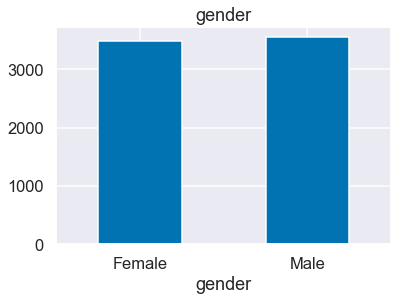

In [19]:
create_bars("gender")

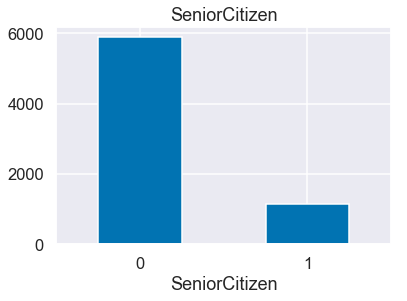

In [20]:
create_bars("SeniorCitizen")

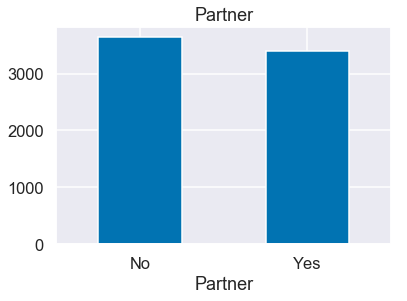

In [21]:
create_bars("Partner")

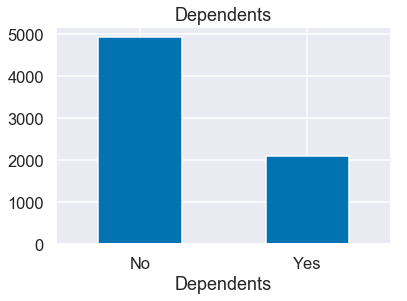

In [22]:
create_bars("Dependents")

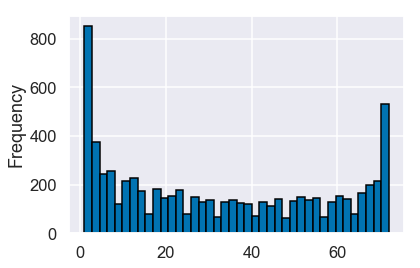

In [23]:
telecom["tenure"].plot.hist(bins=40, edgecolor="k")

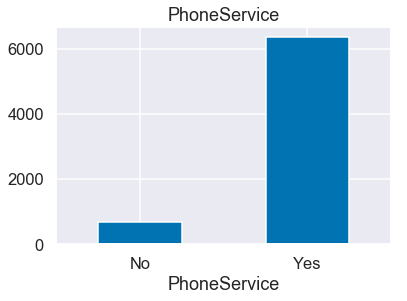

In [24]:
create_bars("PhoneService")

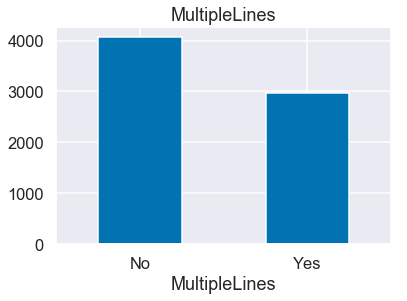

In [25]:
create_bars("MultipleLines")

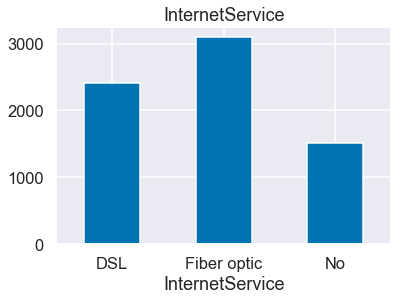

In [26]:
#most of them are using Fiber optics
create_bars("InternetService")

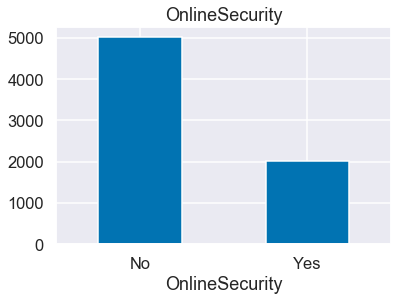

In [27]:
#most of them don't have online security
create_bars("OnlineSecurity")

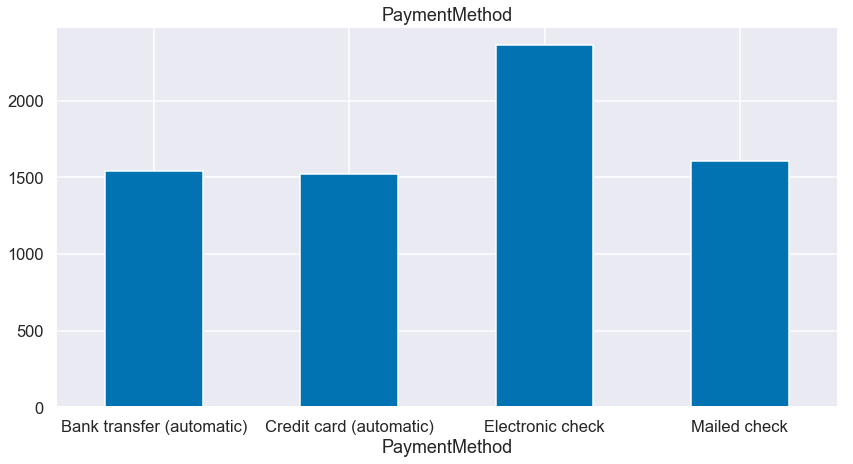

In [28]:
create_bars("PaymentMethod", figsize=(14, 7))                             

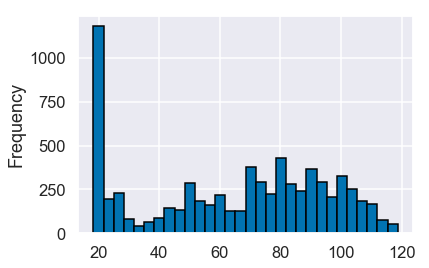

In [29]:
telecom["MonthlyCharges"].plot.hist(bins=30, edgecolor="k")

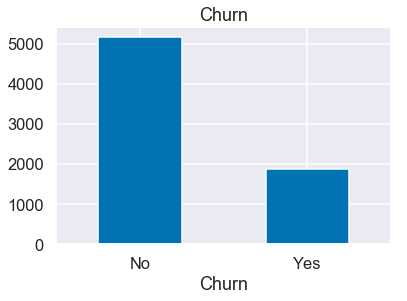

In [30]:
create_bars("Churn")

# Now let's examine Correlations to Churn 

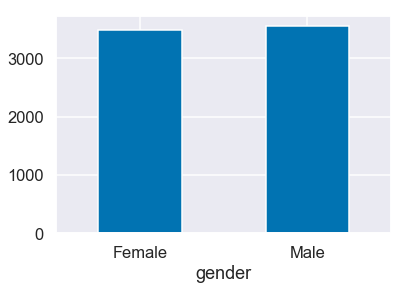

In [31]:
# men and women churn equally
telecom.groupby("gender")["Churn"].count().plot.bar(rot=0)

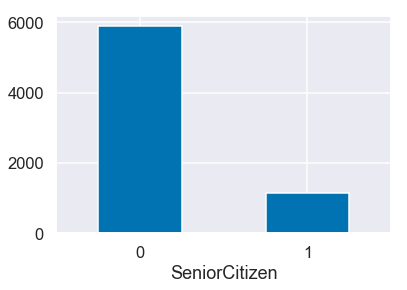

In [29]:
# Seniors churn much less
telecom.groupby("SeniorCitizen")["Churn"].count().plot.bar(rot=0)

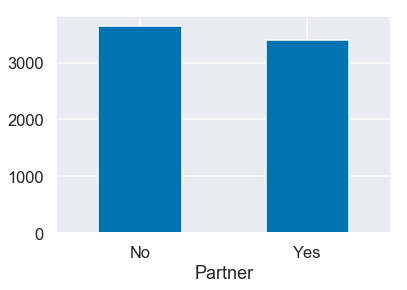

In [30]:
telecom.groupby("Partner")["Churn"].count().plot.bar(rot=0)

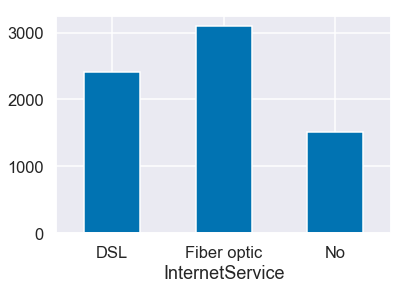

In [30]:
# Those with fiber optic internet service churn more
telecom.groupby("InternetService")["Churn"].count().plot.bar(rot=0)

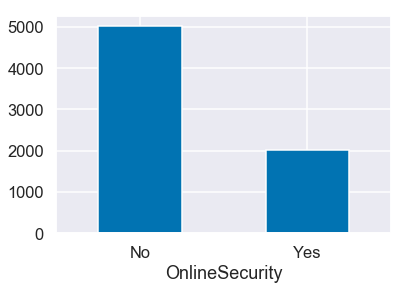

In [31]:
# Those without internet security churn more
telecom.groupby("OnlineSecurity")["Churn"].count().plot.bar(rot=0)

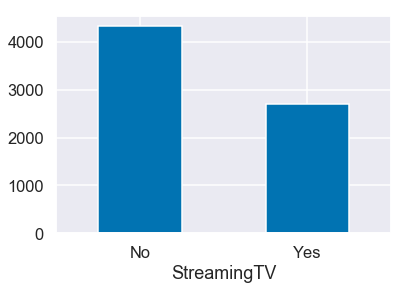

In [32]:
# Those without this service churn more
telecom.groupby("StreamingTV")["Churn"].count().plot.bar(rot=0)

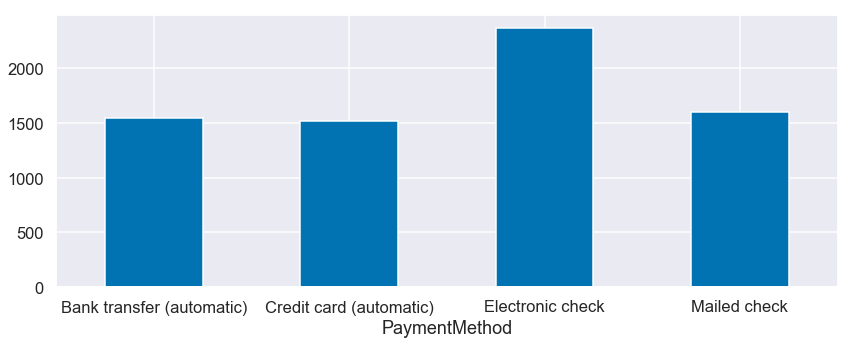

In [33]:
# Those paying with Electronic check churn more
telecom.groupby("PaymentMethod")["Churn"].count().plot.bar(rot=0, figsize=(14, 5))

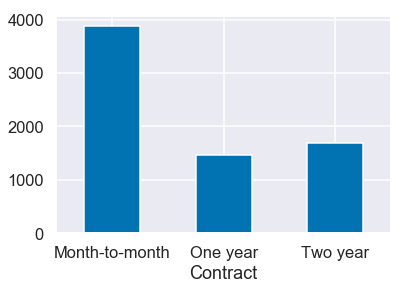

In [34]:
# Those who pay month-to-month churn more
telecom.groupby("Contract")["Churn"].count().plot.bar(rot=0)

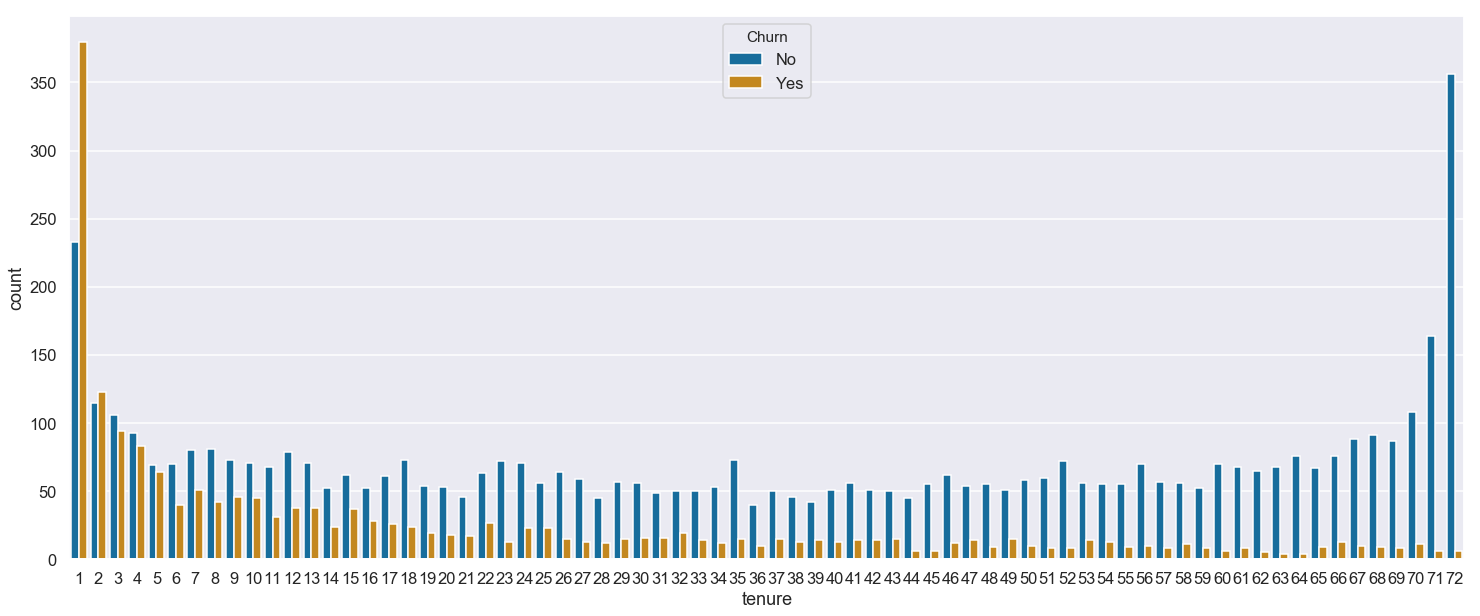

In [32]:
#customers that have been in this company for longer periods are less likely to leave
plt.figure(figsize = (25,10))
sns.countplot(telecom['tenure'], hue = telecom.Churn)

# Data Cleaning

Fix data types : categorical to numerical

In [35]:
telecom_v2 = telecom.copy()

In [36]:
telecom_v2 = telecom_v2.drop(columns=["customerID"])  # drop since each customerID appears only once

In [37]:
binary_features = [c for c in telecom_v2.columns if telecom_v2[c].nunique() == 2]
multi_features = [c for c in telecom_v2.columns if 2 < telecom_v2[c].nunique() < 6]

In [38]:
from sklearn.preprocessing import LabelEncoder

In [39]:
le = LabelEncoder()
for c in binary_features :
    telecom_v2[c] = le.fit_transform(telecom_v2[c])

In [40]:
# convert multi-categorical (more than 2 categories to on-hot encoded vectors)
telecom_v2 = pd.get_dummies(data=telecom_v2, columns=multi_features)

In [41]:
telecom_v2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,0,1,0,1,0,0,0,0,1,0


In [42]:
# columns with features
feature_names = telecom_v2.columns.tolist()
feature_names = [f for f in feature_names if f != "Churn"]

In [43]:
# correlations among features
corr = telecom_v2.corr()

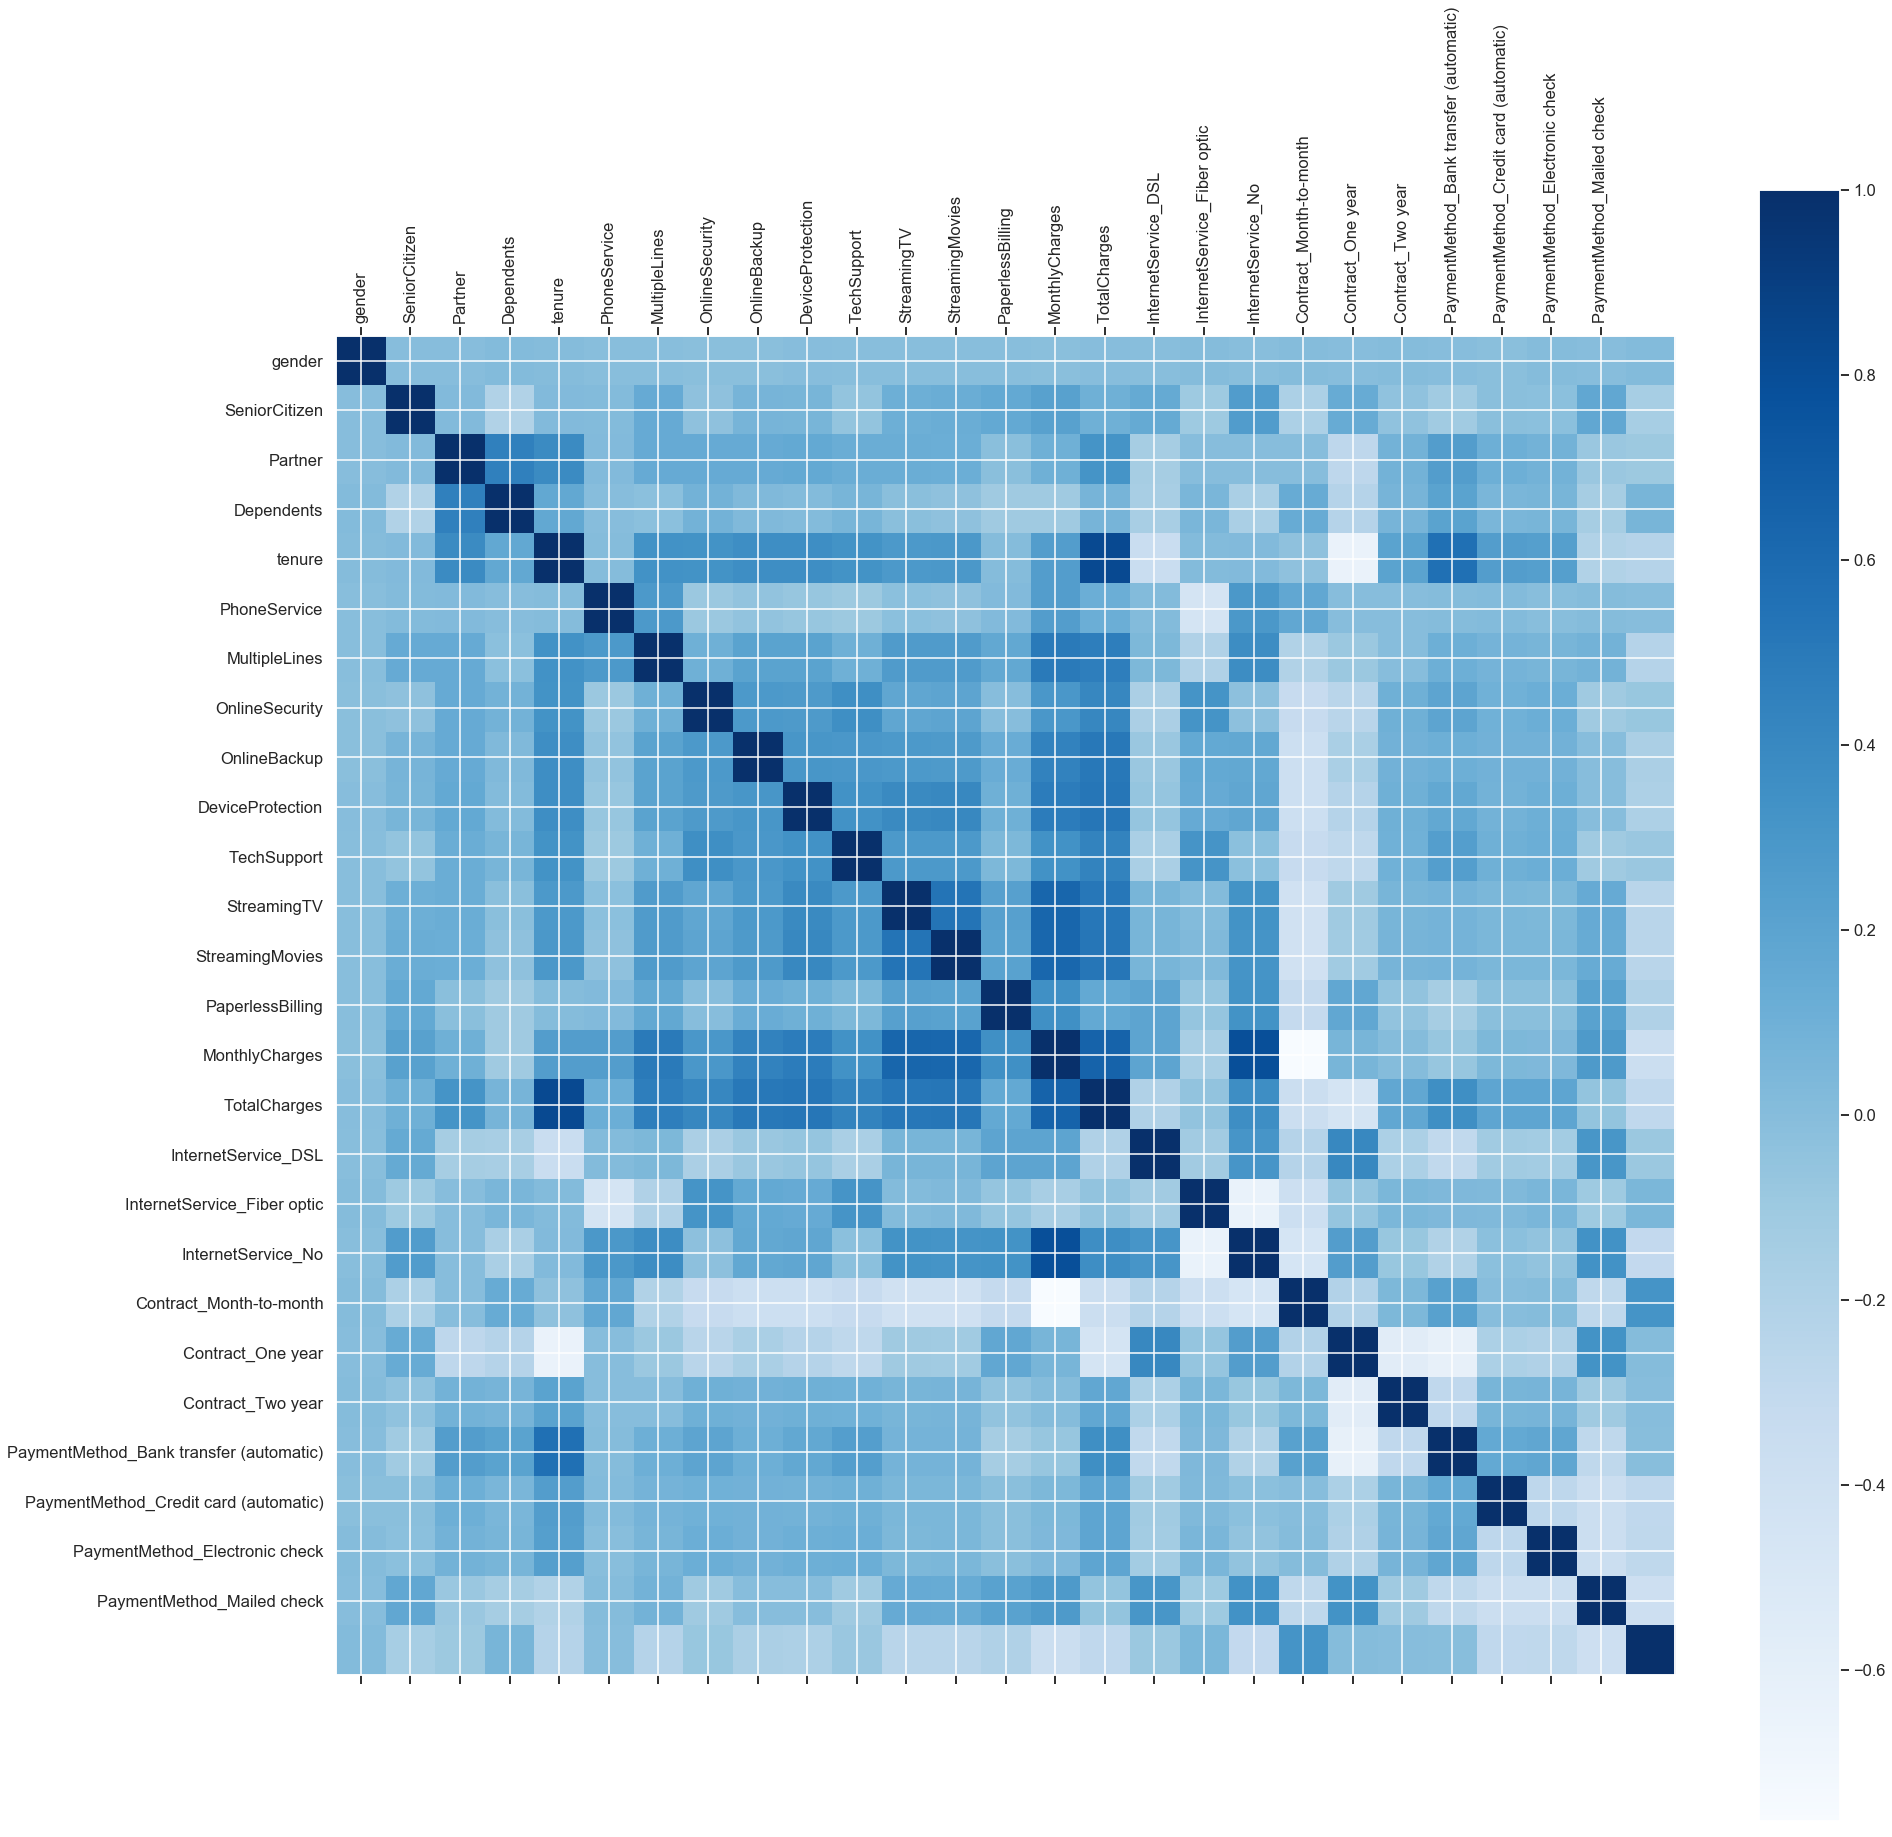

In [67]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='Blues')
fig.colorbar(cax)

plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.yticks(range(len(feature_names)), feature_names, rotation=0)

plt.show()

# Let's Preditct

In [45]:
X = telecom_v2[feature_names].values
y = telecom_v2["Churn"].values

In [46]:
from sklearn.model_selection import train_test_split

In [57]:
# Split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
# scale data to be Gaussian-like
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
clf = RandomForestClassifier(n_estimators=100)

In [62]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [63]:
y_pred = clf.predict(scaler.transform(X_test))

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [65]:
confusion_matrix(y_test, y_pred)

array([[919, 114],
       [199, 175]])

In [66]:
accuracy_score(y_test, y_pred)

0.7775408670931059

# Trying to merge

I don't understand how to do analysis combining two different datasets without "1-1" match.
I'm using an external dataset concerning employee attrition from :  https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/

In [36]:
url="https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-HR-Employee-Attrition.csv?cm_mc_uid=42350349240115511137586&cm_mc_sid_50200000=45908701555553419345&cm_mc_sid_52640000=56761781555553419350"
m=requests.get(url).content
df2 = pd.read_csv(io.StringIO(m.decode('utf-8')))
df2.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [37]:
df2.shape

(1470, 35)

In [38]:
print ("\nMissing values :\n",df2.isnull().sum())


Missing values :
 Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole   

Merge these datasets:

In [45]:
merge_df = telecom.merge(df2,left_on='Churn',right_on='Attrition')
merge_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
1,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
2,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
3,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,4,Male,79,3,1,Laboratory Technician,4,Single,3068,11864,0,Y,No,13,3,3,80,0,8,2,2,7,7,3,6
4,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,3,Female,81,4,1,Laboratory Technician,1,Married,2670,9964,4,Y,Yes,20,4,1,80,3,12,3,2,1,0,0,0
